# Preparação

In [1]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

from time import time

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd 'drive/My Drive/RSDD/util-conservado-4imgs'

/content/drive/.shortcut-targets-by-id/1fnUO42Y1JIVhpQTvYUVLczSGjkzFv64h/RSDD/util-conservado-4imgs


# Carregamento dos dados

In [4]:
points = pd.read_csv("points.csv")
points.describe()

,PointId,Longitude,Latitude,hectare deforested,Diff,Class,Quadrant
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,12799.313750,-55.942220,-12.682402,8.814995,-0.258980,1.000000,13.241250
std,7172.996435,2.583838,2.388511,31.960441,0.159501,1.000313,5.819619
min,23.000000,-61.589106,-17.796606,0.000000,-0.743362,0.000000,1.000000
25%,6793.000000,-57.790023,-14.916701,0.000000,-0.387263,0.000000,8.000000
50%,12595.500000,-56.279001,-12.003502,0.026026,-0.252773,1.000000,13.000000
75%,18713.250000,-54.387110,-10.467609,6.321756,-0.117162,2.000000,18.000000
max,25177.000000,-50.421533,-8.850222,681.439085,-0.004523,2.000000,24.000000


In [5]:
bands = pd.read_csv("bands.csv")
#bands.columns = ['PointId', 'Year', "Month", "Day", "Class", "Index", "Latitude", "Longitude", "Band1", "Band2", "Band3", "Band4", "Band5", "Band6", "Band7", "Band8", "Band8a", "Band9", "Band10", "Band11", "Band12"]
bands.describe()

,PointId,Day,Month,Year,Longitude,Latitude,Index,Cloud,CloudShadow,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,Band8a,Band9,Band10,Band11,Band12,ndvi,savi
count,230400.000000,230400.000000,230400.000000,230400.0,230400.000000,230400.000000,230400.000000,230400.0,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000
mean,12799.313750,13.757344,7.746406,2017.0,-55.942220,-12.682402,18.500000,0.0,0.011871,1275.475247,998.154227,903.034601,690.926567,1038.720569,2203.044674,2742.536827,2679.966623,3122.045078,631.004453,15.256181,1856.664431,878.635056,0.593431,0.890010
std,7170.770085,8.331061,0.841078,0.0,2.583036,2.387769,10.388317,0.0,0.108304,300.685068,303.271887,275.701201,355.808458,311.315251,380.604594,506.464601,518.721239,553.296594,161.267445,13.451287,582.121208,480.839722,0.172041,0.258022
min,23.000000,1.000000,7.000000,2017.0,-61.589334,-17.796832,1.000000,0.0,0.000000,955.000000,662.000000,470.000000,251.000000,395.000000,716.000000,774.000000,646.000000,778.000000,156.000000,4.000000,443.000000,158.000000,-0.185130,-0.277662
25%,6793.000000,6.000000,7.000000,2017.0,-57.790140,-14.916814,9.750000,0.0,0.000000,1103.000000,817.000000,723.000000,442.000000,812.000000,1952.000000,2408.000000,2345.000000,2766.000000,526.000000,10.000000,1439.000000,557.000000,0.537265,0.805776
50%,12595.500000,15.000000,7.000000,2017.0,-56.279001,-12.003502,18.500000,0.0,0.000000,1166.000000,894.000000,835.000000,582.000000,977.000000,2191.000000,2714.000000,2652.000000,3102.000000,615.000000,11.000000,1698.000000,716.000000,0.645600,0.968239
75%,18713.250000,20.000000,9.000000,2017.0,-54.386995,-10.467496,27.250000,0.0,0.000000,1332.000000,1073.000000,997.000000,798.000000,1182.000000,2438.000000,3063.000000,3008.000000,3472.000000,724.000000,13.000000,2116.000000,1036.000000,0.714756,1.071971
max,25177.000000,30.000000,9.000000,2017.0,-50.421304,-8.849995,36.000000,0.0,1.000000,4471.000000,4733.000000,4184.000000,4339.000000,4421.000000,4771.000000,5550.000000,5486.000000,5875.000000,2104.000000,156.000000,8856.000000,11956.000000,0.858981,1.288361


## Cálculo dos índices

In [6]:
# NDVI = (band8 - band4) / (band8 + band4)
#bands['ndvi'] = bands.apply(lambda row: (row.Band8 - row.Band4) / (row.Band8 + row.Band4), axis=1)

# SAVI = (band8 - band4) / (band8 + band4 + 0.5) * 1.5
#bands['savi'] = bands.apply(lambda row: (row.Band8 - row.Band4) / (row.Band8 + row.Band4 + 0.5) * 1.5, axis=1)

# "NDVI-GREEN": "$B03 * ($B08 - $B04) / ($B08 + $B04)"
bands['ndvi-green'] = bands.apply(lambda row: row.Band3 * (row.Band8 - row.Band4 ) / (row.Band8 + row.Band4), axis=1)

# "PSSRa": "$B08 / $B04"
bands['pssra'] = bands.apply(lambda row: row.Band8 / row.Band4, axis=1)

# "PSSRc": "$B08 / $B02",
bands['pssrc'] = bands.apply(lambda row: row.Band8 / row.Band2, axis=1)

# "NDWI": "($B03 - $B08) / ($B03 + $B08)"
bands['ndwi'] = bands.apply(lambda row: (row.Band3 - row.Band8) / (row.Band3 + row.Band8), axis=1)

# "MNDWI": "($B03 - $B11) / ($B03 + $B11)"
bands['mndwi'] = bands.apply(lambda row: (row.Band3 - row.Band11) / (row.Band3 + row.Band11), axis=1)

# "MSI":  "$B11 / $B08"
bands['msi'] = bands.apply(lambda row: row.Band11 / row.Band8, axis=1)


bands.describe()

,PointId,Day,Month,Year,Longitude,Latitude,Index,Cloud,CloudShadow,Band1,Band2,Band3,Band4,Band5,Band6,Band7,Band8,Band8a,Band9,Band10,Band11,Band12,ndvi,savi,ndvi-green,pssra,pssrc,ndwi,mndwi,msi
count,230400.000000,230400.000000,230400.000000,230400.0,230400.000000,230400.000000,230400.000000,230400.0,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000,230400.000000
mean,12799.313750,13.757344,7.746406,2017.0,-55.942220,-12.682402,18.500000,0.0,0.011871,1275.475247,998.154227,903.034601,690.926567,1038.720569,2203.044674,2742.536827,2679.966623,3122.045078,631.004453,15.256181,1856.664431,878.635056,0.593431,0.890010,499.563555,4.691340,2.854422,-0.493397,-0.339888,0.723131
std,7170.770085,8.331061,0.841078,0.0,2.583036,2.387769,10.388317,0.0,0.108304,300.685068,303.271887,275.701201,355.808458,311.315251,380.604594,506.464601,518.721239,553.296594,161.267445,13.451287,582.121208,480.839722,0.172041,0.258022,112.048131,1.998508,0.810917,0.125143,0.090564,0.288875
min,23.000000,1.000000,7.000000,2017.0,-61.589334,-17.796832,1.000000,0.0,0.000000,955.000000,662.000000,470.000000,251.000000,395.000000,716.000000,774.000000,646.000000,778.000000,156.000000,4.000000,443.000000,158.000000,-0.185130,-0.277662,-386.367307,0.687578,0.646275,-0.745786,-0.655018,0.290853
25%,6793.000000,6.000000,7.000000,2017.0,-57.790140,-14.916814,9.750000,0.0,0.000000,1103.000000,817.000000,723.000000,442.000000,812.000000,1952.000000,2408.000000,2345.000000,2766.000000,526.000000,10.000000,1439.000000,557.000000,0.537265,0.805776,447.215525,3.322132,2.379108,-0.576465,-0.395810,0.522939
50%,12595.500000,15.000000,7.000000,2017.0,-56.279001,-12.003502,18.500000,0.0,0.000000,1166.000000,894.000000,835.000000,582.000000,977.000000,2191.000000,2714.000000,2652.000000,3102.000000,615.000000,11.000000,1698.000000,716.000000,0.645600,0.968239,509.912822,4.643334,2.878727,-0.522767,-0.347730,0.625238
75%,18713.250000,20.000000,9.000000,2017.0,-54.386995,-10.467496,27.250000,0.0,0.000000,1332.000000,1073.000000,997.000000,798.000000,1182.000000,2438.000000,3063.000000,3008.000000,3472.000000,724.000000,13.000000,2116.000000,1036.000000,0.714756,1.071971,569.556081,6.011549,3.388816,-0.454721,-0.298123,0.825039
max,25177.000000,30.000000,9.000000,2017.0,-50.421304,-8.849995,36.000000,0.0,1.000000,4471.000000,4733.000000,4184.000000,4339.000000,4421.000000,4771.000000,5550.000000,5486.000000,5875.000000,2104.000000,156.000000,8856.000000,11956.000000,0.858981,1.288361,899.822625,13.182482,6.815094,0.155618,0.330357,4.371175


## Análise dos dados

In [7]:
# Análise
dadosParaAnalise = bands.groupby(['PointId', 'Month', 'Day'])["PointId", 'Month', 'Day', "Band1", "Band2", "Band3", "Band4", "Band5", "Band6", "Band7", "Band8", "Band8a", "Band9", "Band10", "Band11", "Band12", "ndvi", "savi", "ndvi-green", "pssra", "pssrc", "ndwi", "mndwi", "msi"].mean()
dadosParaAnalise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


PointId  Month   Day  ...      ndwi     mndwi       msi
PointId Month Day                        ...                              
23      7     1       23.0    7.0   1.0  ... -0.543797 -0.306280  0.557474
              6       23.0    7.0   6.0  ... -0.447992 -0.316267  0.737823
              26      23.0    7.0  26.0  ... -0.411466 -0.443792  1.088268
        9     4       23.0    9.0   4.0  ... -0.342735 -0.429105  1.228471
39      7     1       39.0    7.0   1.0  ... -0.585386 -0.306735  0.493780
...                    ...    ...   ...  ...       ...       ...       ...
25176   9     18   25176.0    9.0  18.0  ... -0.527987 -0.322534  0.606831
25177   7     15   25177.0    7.0  15.0  ... -0.535710 -0.336298  0.615506
              20   25177.0    7.0  20.0  ... -0.519416 -0.317857  0.617376
        8     4    25177.0    8.0   4.0  ... -0.522888 -0.324924  0.621641
        9     18   25177.0    9.0  18.0  ... -0.507596 -0.299255  0.608312

[6400 rows x 24 columns]

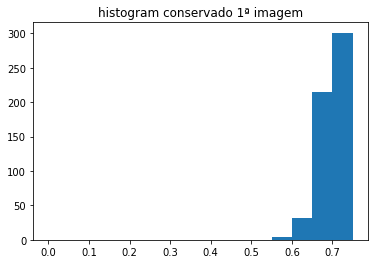

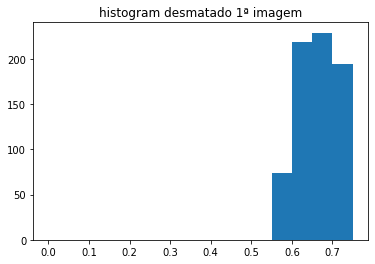

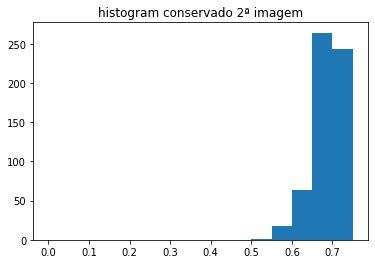

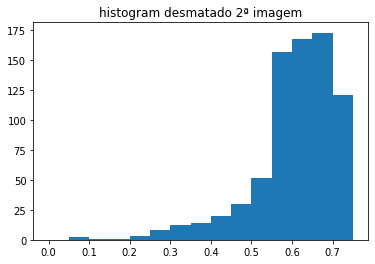

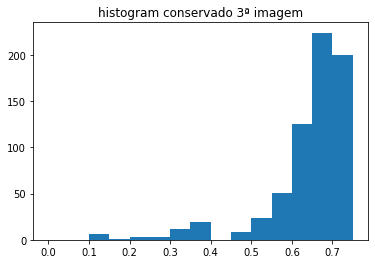

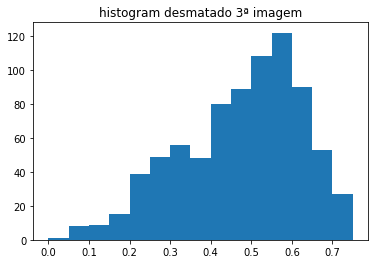

In [8]:
numeroDePontos = 1600
pD = 0
pC = 0
i = 0

ndvisDesmatado = np.empty([3, 800])
ndvisConservado = np.empty([3, 800])

while (i < 1600*4):

    # Obter bandas e PointID
    row1 = dadosParaAnalise.iloc[i]
    row2 = dadosParaAnalise.iloc[i+1]
    row3 = dadosParaAnalise.iloc[i+2]
    pointId = row1['PointId']

    # Consultar POINTS e obter classe
    pointRow = points.loc[points['PointId'] == pointId]
    classe = pointRow['Class'].iloc[0]

    if classe == 2:
      ndvisDesmatado[0, pD] = row1["ndvi"]
      ndvisDesmatado[1, pD] = row2["ndvi"]
      ndvisDesmatado[2, pD] = row3["ndvi"]
      pD = pD + 1
    else:
      ndvisConservado[0, pC] = row1["ndvi"]
      ndvisConservado[1, pC] = row2["ndvi"]
      ndvisConservado[2, pC] = row3["ndvi"]
      pC = pC + 1

    i = i + 4

plt.hist(ndvisConservado[0], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram conservado 1ª imagem") 
plt.show()

plt.hist(ndvisDesmatado[0], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram desmatado 1ª imagem") 
plt.show()

plt.hist(ndvisConservado[1], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram conservado 2ª imagem") 
plt.show()

plt.hist(ndvisDesmatado[1], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram desmatado 2ª imagem") 
plt.show()

plt.hist(ndvisConservado[2], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram conservado 3ª imagem") 
plt.show()

plt.hist(ndvisDesmatado[2], bins = np.arange(0, 0.8, 0.05)) 
plt.title("histogram desmatado 3ª imagem") 
plt.show()

# Preparação do conjunto de dados

In [9]:
# Agrupamento dos dados de um mesmo ponto
dados = bands.groupby(['PointId', 'Month', 'Day'])["PointId", "Band1", "Band2", "Band3", "Band4", "Band5", "Band6", "Band7", "Band8", "Band8a", "Band9", "Band10", "Band11", "Band12", "ndvi", "savi", "ndvi-green", "pssra", "pssrc", "ndwi", "mndwi", "msi"].mean()
dados

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


PointId        Band1  ...     mndwi       msi
PointId Month Day                        ...                    
23      7     1       23.0  1113.888889  ... -0.306280  0.557474
              6       23.0  1236.333333  ... -0.316267  0.737823
              26      23.0  1222.666667  ... -0.443792  1.088268
        9     4       23.0  1457.333333  ... -0.429105  1.228471
39      7     1       39.0  1189.222222  ... -0.306735  0.493780
...                    ...          ...  ...       ...       ...
25176   9     18   25176.0  1179.333333  ... -0.322534  0.606831
25177   7     15   25177.0  1089.888889  ... -0.336298  0.615506
              20   25177.0  1128.777778  ... -0.317857  0.617376
        8     4    25177.0  1131.583333  ... -0.324924  0.621641
        9     18   25177.0  1243.277778  ... -0.299255  0.608312

[6400 rows x 22 columns]

In [10]:
# Separação do conjunto de dados

# Combinações
## 1 - 3 imagens de entrada, todos os atributos
## 2 - 3 imagens de entrada, apenas as bandas
## 3 - 3 imagens de entrada, apenas os índices
## 4 - 2 imagens de entrada, todos os atributos
## 5 - 2 imagens de entrada, apenas as bandas
## 6 - 2 imagens de entrada, apenas os índices

def getXandY (combinacao):

  numeroDePontos = 1600
  bandas = 13
  indices = 8

  if combinacao == 1:
    numeroEntradas = 3 * (bandas + indices)
  elif combinacao == 2:
    numeroEntradas = 3 * (bandas)
  elif combinacao == 3:
    numeroEntradas = 3 * (indices)
  elif combinacao == 4:
    numeroEntradas = 2 * (bandas + indices)
  elif combinacao == 5:
    numeroEntradas = 2 * (bandas)
  elif combinacao == 6:
    numeroEntradas = 2 * (indices)
  else:
    raise Exception("Código de combinação inválido")


  x = np.empty([numeroDePontos, numeroEntradas])
  y = np.empty([numeroDePontos, 2])

  idx = 0
  pontos = 0

  # Passar por cada linha de DADOS
  while (pontos < numeroDePontos):

    # Obter bandas e PointID
    row1 = dados.iloc[idx]
    row2 = dados.iloc[idx+1]
    row3 = dados.iloc[idx+2]
    pointId = row1['PointId']

    # Consultar POINTS e obter classe
    pointRow = points.loc[points['PointId'] == pointId]
    classe = pointRow['Class'].iloc[0]
    
    # Definir X baseado na combinacao
    if combinacao == 1:
      x[pontos] = [row1["Band1"], row1["Band2"], row1["Band3"], row1["Band4"], row1["Band5"], row1["Band6"], row1["Band7"], row1["Band8"], row1["Band8a"], row1["Band9"], row1["Band10"], row1["Band11"], row1["Band12"], row1["ndvi"], row1["savi"], row1["ndvi-green"], row1["pssra"], row1["pssrc"], row1["ndwi"], row1["mndwi"], row1["msi"],
                  row2["Band1"], row2["Band2"], row2["Band3"], row2["Band4"], row2["Band5"], row2["Band6"], row2["Band7"], row2["Band8"], row2["Band8a"], row2["Band9"], row2["Band10"], row2["Band11"], row2["Band12"], row2["ndvi"], row2["savi"], row2["ndvi-green"], row2["pssra"], row2["pssrc"], row2["ndwi"], row2["mndwi"], row2["msi"],
                  row3["Band1"], row3["Band2"], row3["Band3"], row3["Band4"], row3["Band5"], row3["Band6"], row3["Band7"], row3["Band8"], row3["Band8a"], row3["Band9"], row3["Band10"], row3["Band11"], row3["Band12"], row3["ndvi"], row3["savi"], row3["ndvi-green"], row3["pssra"], row3["pssrc"], row3["ndwi"], row3["mndwi"], row3["msi"] ]
    elif combinacao == 2:
      x[pontos] = [row1["Band1"], row1["Band2"], row1["Band3"], row1["Band4"], row1["Band5"], row1["Band6"], row1["Band7"], row1["Band8"], row1["Band8a"], row1["Band9"], row1["Band10"], row1["Band11"], row1["Band12"],
                  row2["Band1"], row2["Band2"], row2["Band3"], row2["Band4"], row2["Band5"], row2["Band6"], row2["Band7"], row2["Band8"], row2["Band8a"], row2["Band9"], row2["Band10"], row2["Band11"], row2["Band12"],
                  row3["Band1"], row3["Band2"], row3["Band3"], row3["Band4"], row3["Band5"], row3["Band6"], row3["Band7"], row3["Band8"], row3["Band8a"], row3["Band9"], row3["Band10"], row3["Band11"], row3["Band12"] ]
    elif combinacao == 3:
      x[pontos] = [row1["ndvi"], row1["savi"], row1["ndvi-green"], row1["pssra"], row1["pssrc"], row1["ndwi"], row1["mndwi"], row1["msi"],
                  row2["ndvi"], row2["savi"], row2["ndvi-green"], row2["pssra"], row2["pssrc"], row2["ndwi"], row2["mndwi"], row2["msi"],
                  row3["ndvi"], row3["savi"], row3["ndvi-green"], row3["pssra"], row3["pssrc"], row3["ndwi"], row3["mndwi"], row3["msi"] ]
    elif combinacao == 4:
      x[pontos] = [row1["Band1"], row1["Band2"], row1["Band3"], row1["Band4"], row1["Band5"], row1["Band6"], row1["Band7"], row1["Band8"], row1["Band8a"], row1["Band9"], row1["Band10"], row1["Band11"], row1["Band12"], row1["ndvi"], row1["savi"], row1["ndvi-green"], row1["pssra"], row1["pssrc"], row1["ndwi"], row1["mndwi"], row1["msi"],
                  row2["Band1"], row2["Band2"], row2["Band3"], row2["Band4"], row2["Band5"], row2["Band6"], row2["Band7"], row2["Band8"], row2["Band8a"], row2["Band9"], row2["Band10"], row2["Band11"], row2["Band12"], row2["ndvi"], row2["savi"], row2["ndvi-green"], row2["pssra"], row2["pssrc"], row2["ndwi"], row2["mndwi"], row2["msi"] ]
    elif combinacao == 5:
      x[pontos] = [row1["Band1"], row1["Band2"], row1["Band3"], row1["Band4"], row1["Band5"], row1["Band6"], row1["Band7"], row1["Band8"], row1["Band8a"], row1["Band9"], row1["Band10"], row1["Band11"], row1["Band12"],
                  row2["Band1"], row2["Band2"], row2["Band3"], row2["Band4"], row2["Band5"], row2["Band6"], row2["Band7"], row2["Band8"], row2["Band8a"], row2["Band9"], row2["Band10"], row2["Band11"], row2["Band12"] ]
    elif combinacao == 6:
      x[pontos] = [row1["ndvi"], row1["savi"], row1["ndvi-green"], row1["pssra"], row1["pssrc"], row1["ndwi"], row1["mndwi"], row1["msi"],
                  row2["ndvi"], row2["savi"], row2["ndvi-green"], row2["pssra"], row2["pssrc"], row2["ndwi"], row2["mndwi"], row2["msi"] ]
    else:
      raise Exception("Código de combinação inválido")
    

    # Definir Y
    if classe == 0:
      # conservado
      y[pontos] = [0, 1]
    else:
      # desmatado
      y[pontos] = [1, 0]


    idx = idx + 4
    pontos = pontos + 1

  return x, y

## Separação entre treinamento e teste

In [11]:
# Separação entre treinamento e teste
def getTreinamentoAndTeste (combinacao):
  x, y = getXandY(combinacao)

  # Normalização
  scX = MinMaxScaler()
  x = scX.fit_transform(x)

  # Separação
  treinoX, testeX, treinoY, testeY = train_test_split(x, y, test_size=0.3, random_state=27, shuffle=True)

  return treinoX, testeX, treinoY, testeY

# Rede neural

## Modelo

In [12]:
def createAnnModel(numeroEntradas, activations, optimizer):
  units = numeroEntradas*2+1

  model = Sequential()
  model.add(Dense(units, input_dim=numeroEntradas, kernel_initializer='normal', activation=activations[0]))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

## Treinamento

In [13]:
def treinamento (treinoX, treinoY):

  numeroEntradas = treinoX.shape[1]

  tempoInicio = time()

  model = createAnnModel(numeroEntradas, ['relu','sigmoid'], 'Adam')
  history = model.fit(treinoX, treinoY, validation_split=0.25, epochs=200, shuffle=True)

  tempo = time() - tempoInicio

  return model, history, tempo

# Análise dos resultados

In [14]:
def plotRestult (history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [15]:
def ConfusionMatrix (model, testeX, testeY):
  predY = model.predict(testeX)
  matrix = confusion_matrix(testeY.argmax(axis=1), predY.argmax(axis=1))

  print("Matriz confusão:")
  print(matrix)

  tn = matrix[0,0]
  fp = matrix[0,1]
  fn = matrix[1,0]
  tp = matrix[1,1]

  return tn, fp, fn, tp

# Execução

Epoch 1/200
27/27 [==============================] - 0s 7ms/step - loss: 0.5422 - accuracy: 0.8560 - val_loss: 0.4018 - val_accuracy: 0.9179
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3702 - accuracy: 0.8798 - val_loss: 0.2770 - val_accuracy: 0.9214
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3054 - accuracy: 0.8881 - val_loss: 0.2285 - val_accuracy: 0.9250
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.8881 - val_loss: 0.2313 - val_accuracy: 0.9286
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.8976 - val_loss: 0.2419 - val_accuracy: 0.9107
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2555 - accuracy: 0.8952 - val_loss: 0.2026 - val_accuracy: 0.9321
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.9048 - val_loss: 0.1888 - val_accuracy: 0.9321
Epoch 8/200
2

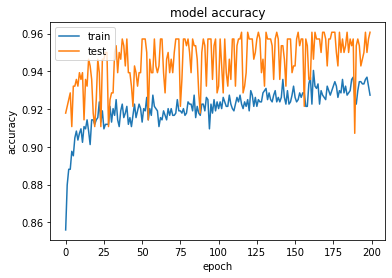

Matriz confusão:
[[236  15]
 [ 12 217]]
Epoch 1/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6116 - accuracy: 0.6464 - val_loss: 0.5495 - val_accuracy: 0.8143
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4982 - accuracy: 0.8464 - val_loss: 0.4240 - val_accuracy: 0.9071
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8786 - val_loss: 0.3410 - val_accuracy: 0.9250
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3511 - accuracy: 0.8952 - val_loss: 0.2854 - val_accuracy: 0.9179
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3180 - accuracy: 0.8952 - val_loss: 0.2627 - val_accuracy: 0.9321
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8952 - val_loss: 0.2545 - val_accuracy: 0.9286
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8893 - val_loss: 0.2

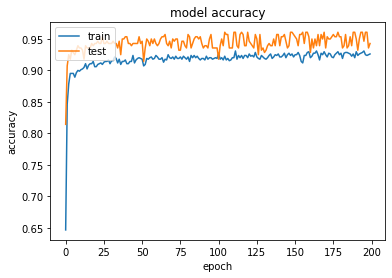

Matriz confusão:
[[238  13]
 [ 19 210]]
Epoch 1/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6663 - accuracy: 0.6167 - val_loss: 0.6304 - val_accuracy: 0.8393
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.8012 - val_loss: 0.5526 - val_accuracy: 0.8643
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.5366 - accuracy: 0.8214 - val_loss: 0.4763 - val_accuracy: 0.8750
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4756 - accuracy: 0.8298 - val_loss: 0.4321 - val_accuracy: 0.8714
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.8452 - val_loss: 0.3628 - val_accuracy: 0.8893
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3910 - accuracy: 0.8476 - val_loss: 0.3359 - val_accuracy: 0.9107
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.8750 - val_loss: 0.3

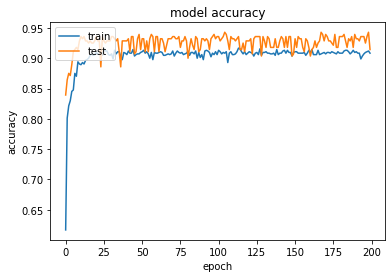

Matriz confusão:
[[241  10]
 [ 24 205]]
Epoch 1/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6038 - accuracy: 0.7452 - val_loss: 0.5021 - val_accuracy: 0.8857
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4605 - accuracy: 0.8571 - val_loss: 0.3818 - val_accuracy: 0.8964
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8631 - val_loss: 0.3064 - val_accuracy: 0.9214
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3312 - accuracy: 0.8762 - val_loss: 0.2739 - val_accuracy: 0.9179
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8786 - val_loss: 0.2474 - val_accuracy: 0.9214
Epoch 6/200
27/27 [==============================] - 0s 3ms/step - loss: 0.2996 - accuracy: 0.8905 - val_loss: 0.2418 - val_accuracy: 0.9250
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2898 - accuracy: 0.8810 - val_loss: 0.2

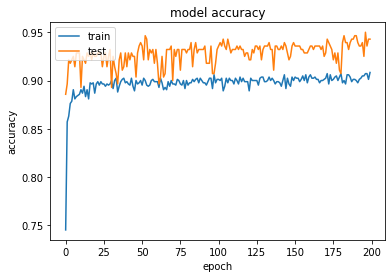

Matriz confusão:
[[225  26]
 [ 12 217]]
Epoch 1/200
27/27 [==============================] - 0s 12ms/step - loss: 0.6375 - accuracy: 0.5786 - val_loss: 0.5977 - val_accuracy: 0.6893
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.8179 - val_loss: 0.5158 - val_accuracy: 0.8143
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4824 - accuracy: 0.8298 - val_loss: 0.4237 - val_accuracy: 0.8929
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8583 - val_loss: 0.3610 - val_accuracy: 0.9107
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3771 - accuracy: 0.8619 - val_loss: 0.3186 - val_accuracy: 0.9214
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3475 - accuracy: 0.8690 - val_loss: 0.3035 - val_accuracy: 0.9107
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3280 - accuracy: 0.8714 - val_loss: 0.

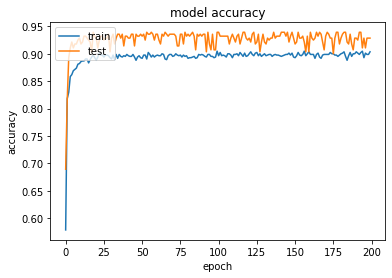

Matriz confusão:
[[231  20]
 [ 20 209]]
Epoch 1/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6714 - accuracy: 0.7488 - val_loss: 0.6411 - val_accuracy: 0.7786
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 0.6333 - accuracy: 0.7571 - val_loss: 0.5998 - val_accuracy: 0.8429
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.8226 - val_loss: 0.5543 - val_accuracy: 0.8500
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.8238 - val_loss: 0.5137 - val_accuracy: 0.8571
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.8214 - val_loss: 0.4686 - val_accuracy: 0.8750
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.8321 - val_loss: 0.4274 - val_accuracy: 0.8750
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.8524 - val_loss: 0.4

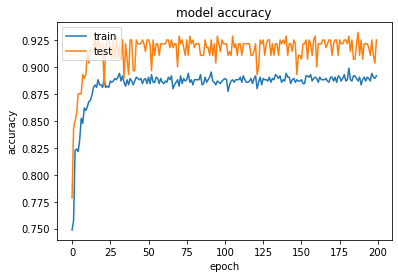

Matriz confusão:
[[228  23]
 [ 12 217]]


In [16]:
numCombinacoes = 6
results = np.empty([numCombinacoes, 8])

for i in range(numCombinacoes):
  combinacao = i + 1
  
  treinoX, testeX, treinoY, testeY = getTreinamentoAndTeste(combinacao)
  model, history, tempo = treinamento(treinoX, treinoY)

  plotRestult(history)

  tn, fp, fn, tp = ConfusionMatrix(model, testeX, testeY)
  
  precision = tp / (tp+fp)
  accuracy = (tp+tn) / (tp+tn+fp+fn)

  results[i] = [combinacao, tn, fp, fn, tp, precision, accuracy, tempo]

In [17]:
print ("#"
    + "\t" + "TN"
    + "\t" + "FP"
    + "\t" + "FN"
    + "\t" + "TP"
    + "\t" + "Precision(%)"
    + "\t" + "Accuracy (%)"
    + "\t" + "Tempo (s)" )

for i in range(numCombinacoes):
  combinacao, tn, fp, fn, tp, precision, accuracy, tempo = results[i]
  print (str(combinacao)
      + "\t" + str(tn)
      + "\t" + str(fp)
      + "\t" + str(fn)
      + "\t" + str(tp)
      + "\t" + str(round(precision*100,2))
      + "\t" + str(round(accuracy*100,2))
      + "\t" + str(round(tempo, 2)) )

#	TN	FP	FN	TP	Precision(%)	Accuracy (%)	Tempo (s)
1.0	236.0	15.0	12.0	217.0	93.53	94.38	13.65
2.0	238.0	13.0	19.0	210.0	94.17	93.33	12.52
3.0	241.0	10.0	24.0	205.0	95.35	92.92	12.48
4.0	225.0	26.0	12.0	217.0	89.3	92.08	13.59
5.0	231.0	20.0	20.0	209.0	91.27	91.67	12.7
6.0	228.0	23.0	12.0	217.0	90.42	92.71	12.06
